In [1]:
push!(LOAD_PATH, ".")  # Append current directory to Julia LOAD_PATH

# using RocketUtils
using Plots, OrdinaryDiffEq, LinearAlgebra

const G = 1e-3  # Gravitational constant

0.001

In [2]:
struct Body{m <: Float64, r <: Vector{Float64}, s <: Float64, label <: String}
    m::m
    r::r
    s::s
    label::label
end

In [3]:
function diffeq(r, p, t)
    hd = Int(length(r) / 2)  # Half-dimension of r, split r from v
    dr = Vector{Float64}(undef, 2*hd)  # Allocate dr

    dr[1 : hd] = r[hd+1 : 2*hd]  # ∂ₜr = v
    dr[hd+1 : 2*hd] = [G for i in 1:hd]  # ∂ₜv = a
    return dr
end

diffeq (generic function with 1 method)

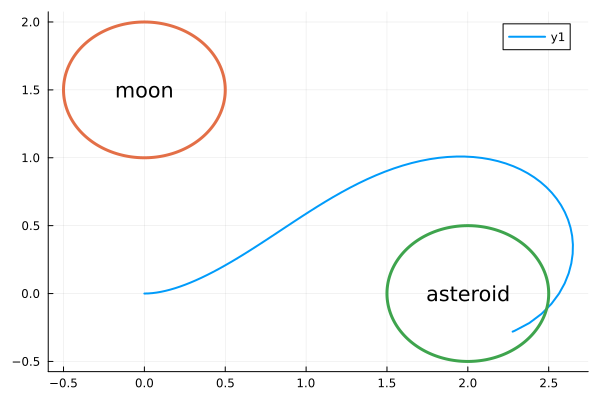

In [7]:
function gravity(r, m, obj::Body)
    r21 = (obj.r - r) / norm(r - obj.r)  # Vector between objects
    return G * m * obj.m * r21 / norm(r - obj.r)^2  # Vectorized gravity
end


function rocket_ODE(r, p, t)
    m, halfdim, bods = p

    # Acceleration
    a = zeros(halfdim)
    for b in bods
        a += gravity(r[1:halfdim], m, b)
    end

    return [r[halfdim+1:2*halfdim] ; a]
end



mass = 1.
r0 = [0. ; 0. ; 0.4 ; 0.]
ob1 = Body(1e3, [0.; 1.5], .5, "moon")
ob2 = Body(1e3, [2.; 0.], .5, "asteroid")
objs = [ob1, ob2]
halfdim = Int(length(r0) / 2)  # Half-dimension of r, split r from v

T = 300

condition(r, t, integrator) = Bool(sum([norm(ob.r - r[1:halfdim]) < ob.s for ob in objs]))
affect!(integrator) = terminate!(integrator)
cb = DiscreteCallback(condition,affect!)

prob = ODEProblem(rocket_ODE, r0, (0., T), (mass, halfdim, objs))
sol = solve(prob, Tsit5(), callback=cb)

ts = range(0, T; length=5000)
# plot(ts, sol(ts)[1,:], lw=2)
# plot!(ts, sol(ts)[2,:], lw=2, ls=:dash)
function circle(ob::Body)
    θ = range(0, 2π; length=500)
    ob.r[1] .+ ob.s * sin.(θ), ob.r[2] .+ ob.s * cos.(θ)
end

p = plot()
plot!(p, sol(ts)[1,:], sol(ts)[2,:], lw=2)
for ob in objs
    plot!(p, circle(ob), lw=3, label=nothing)
    annotate!(p, ob.r[1], ob.r[2], ob.lab)
end

display(p)
